In [1]:
# Build mixed FER/EDFER splits as requested:
# TRAIN = all EDFER + 75% FER2013/train
# VAL   = 25% FER2013/train
# TEST  = FER2013/test (or PrivateTest)
from pathlib import Path
import shutil, random

# --- Config ---
EDFER_ROOT   = Path("/kaggle/input/emotion-detection-fer")
FER2013_ROOT = Path("/kaggle/input/fer2013")
OUT_ROOT     = Path("/kaggle/content/fer2013_by_usage_1")

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}
SEED = 42
FER_TRAIN_FRAC_FOR_TRAIN = 0.75   # remaining 0.25 -> val

# EDFER label mapping
EDFER_MAP = {"disgusted": "disgust", "fearful": "fear", "surprised": "surprise"}

# --- Helpers ---
def is_img(p: Path) -> bool:
    return p.is_file() and p.suffix.lower() in IMG_EXTS

def map_edfer(label: str) -> str:
    l = label.strip().lower()
    return EDFER_MAP.get(l, l)

def norm_fer(label: str) -> str:
    return label.strip().lower()

def ensure_dirs(*dirs: Path):
    for d in dirs: d.mkdir(parents=True, exist_ok=True)

def class_dirs(root: Path):
    return [d for d in sorted(root.iterdir()) if d.is_dir()]

def copy_all(files, dst_dir: Path, prefix: str):
    ensure_dirs(dst_dir)
    for f in files:
        shutil.copy2(f, dst_dir / f"{prefix}__{f.name}")

def find_first_dir(root: Path, names):
    for n in names:
        p = root / n
        if p.is_dir(): return p
    return None

# --- Output skeleton ---
OUT_TRAIN, OUT_VAL, OUT_TEST = OUT_ROOT/"train", OUT_ROOT/"val", OUT_ROOT/"test"
ensure_dirs(OUT_TRAIN, OUT_VAL, OUT_TEST)

if not EDFER_ROOT.exists():
    raise FileNotFoundError(f"Missing EDFER at {EDFER_ROOT}")
if not FER2013_ROOT.exists():
    raise FileNotFoundError(f"Missing FER2013 at {FER2013_ROOT}")

rng = random.Random(SEED)

# === 1) EDFER: put the ENTIRE dataset into TRAIN ===
# We’ll copy from any present split folders into OUT_TRAIN (with label mapping).
def copy_entire_edfer_to_train(edfer_root: Path):
    split_candidates = ["train","Train","val","validation","valid","Val","Validation","Valid","test","Test","PrivateTest"]
    # Use any subdir that contains class folders
    for name in split_candidates:
        sroot = edfer_root / name
        if not sroot.is_dir(): 
            continue
        for cls in class_dirs(sroot):
            label = map_edfer(cls.name)
            files = [p for p in sorted(cls.iterdir()) if is_img(p)]
            if not files: 
                continue
            copy_all(files, OUT_TRAIN/label, prefix="edfer")

copy_entire_edfer_to_train(EDFER_ROOT)

# === 2) FER2013: split TRAIN 75/25 per-class into TRAIN/VAL ===
fer_train = find_first_dir(FER2013_ROOT, ["train","Train","Training"])
if fer_train is None:
    raise FileNotFoundError(f"No FER2013 train split found under {FER2013_ROOT}")

for cls in class_dirs(fer_train):
    label = norm_fer(cls.name)
    files = [p for p in sorted(cls.iterdir()) if is_img(p)]
    if not files:
        continue
    # deterministic per-class shuffle
    r = random.Random(SEED + hash(label) % (2**31))
    r.shuffle(files)
    k = max(1, int(round(len(files) * FER_TRAIN_FRAC_FOR_TRAIN)))
    train_files, val_files = files[:k], files[k:]
    copy_all(train_files, OUT_TRAIN/label, prefix="fer2013_tr")
    copy_all(val_files,   OUT_VAL/label,   prefix="fer2013_val")

# === 3) FER2013: TEST split ===
fer_test = find_first_dir(FER2013_ROOT, ["test","Test","PrivateTest"])
if fer_test is None:
    raise FileNotFoundError(f"No FER2013 test/PrivateTest split found under {FER2013_ROOT}")

for cls in class_dirs(fer_test):
    label = norm_fer(cls.name)
    files = [p for p in sorted(cls.iterdir()) if is_img(p)]
    if files:
        copy_all(files, OUT_TEST/label, prefix="fer2013_test")

# --- Reporting (compact) ---
def count_split(root: Path):
    per_class = {}
    examples = []
    if root.exists():
        for cls in class_dirs(root):
            imgs = [p for p in sorted(cls.iterdir()) if is_img(p)]
            per_class[cls.name] = len(imgs)
            examples.extend(imgs[:3])
    return per_class, [str(p) for p in examples[:6]]

tr_c, tr_ex = count_split(OUT_TRAIN)
va_c, va_ex = count_split(OUT_VAL)
te_c, te_ex = count_split(OUT_TEST)

print("=== Summary ===")
print("Output:", OUT_ROOT)
print("Totals -> train:", sum(tr_c.values()), " val:", sum(va_c.values()), " test:", sum(te_c.values()))
print("\nPer-class (train/val/test):")
for lbl in sorted(set(tr_c)|set(va_c)|set(te_c)):
    print(f"{lbl:>10s}  {tr_c.get(lbl,0):5d} / {va_c.get(lbl,0):5d} / {te_c.get(lbl,0):5d}")
print("\nSamples:")
print(" train:", tr_ex[:5])
print(" val  :", va_ex[:5])
print(" test :", te_ex[:5])


=== Summary ===
Output: /kaggle/content/fer2013_by_usage_1
Totals -> train: 50240  val: 7178  test: 7178

Per-class (train/val/test):
     angry   6991 /   999 /   958
   disgust    763 /   109 /   111
      fear   7170 /  1024 /  1024
     happy  12626 /  1804 /  1774
   neutral   8689 /  1241 /  1233
       sad   8452 /  1208 /  1247
  surprise   5549 /   793 /   831

Samples:
 train: ['/kaggle/content/fer2013_by_usage_1/train/angry/edfer__im0.png', '/kaggle/content/fer2013_by_usage_1/train/angry/edfer__im1.png', '/kaggle/content/fer2013_by_usage_1/train/angry/edfer__im10.png', '/kaggle/content/fer2013_by_usage_1/train/disgust/edfer__im0.png', '/kaggle/content/fer2013_by_usage_1/train/disgust/edfer__im1.png']
 val  : ['/kaggle/content/fer2013_by_usage_1/val/angry/fer2013_val__Training_10269675.jpg', '/kaggle/content/fer2013_by_usage_1/val/angry/fer2013_val__Training_10290703.jpg', '/kaggle/content/fer2013_by_usage_1/val/angry/fer2013_val__Training_10345473.jpg', '/kaggle/content/fer2


--- TRAIN (total 50240) ---
  angry        -> angry    : 6991
  disgust      -> disgust  : 763
  fear         -> fear     : 7170
  happy        -> happy    : 12626
  sad          -> sad      : 8452
  surprise     -> surprise : 5549
  neutral      -> neutral  : 8689

--- VAL (total 7178) ---
  angry        -> angry    : 999
  disgust      -> disgust  : 109
  fear         -> fear     : 1024
  happy        -> happy    : 1804
  sad          -> sad      : 1208
  surprise     -> surprise : 793
  neutral      -> neutral  : 1241

--- TEST (total 7178) ---
  angry        -> angry    : 958
  disgust      -> disgust  : 111
  fear         -> fear     : 1024
  happy        -> happy    : 1774
  sad          -> sad      : 1247
  surprise     -> surprise : 831
  neutral      -> neutral  : 1233


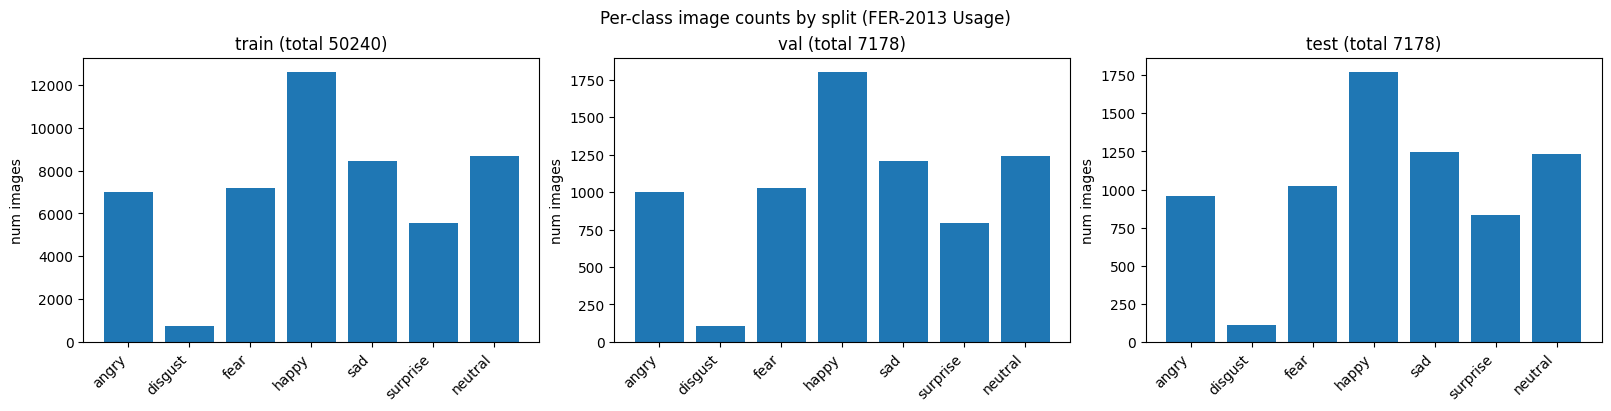

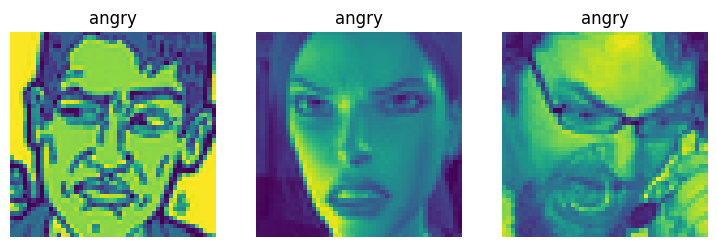

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image

OUT_ROOT = "/kaggle/content/fer2013_by_usage_1"
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp")
LABEL_ORDER = ['angry','disgust','fear','happy','sad','surprise','neutral']
NUM_TO_NAME = {0:'anger',1:'disgust',2:'fear',3:'happy',4:'sad',5:'surprise',6:'neutral'}

def count_classes(split_dir):
    counts = {}
    if not os.path.isdir(split_dir):
        return counts
    for cls in sorted(os.listdir(split_dir)):
        p = os.path.join(split_dir, cls)
        if not os.path.isdir(p): 
            continue
        # count image files
        num = sum(1 for f in os.listdir(p) if f.lower().endswith(IMG_EXTS))
        counts[cls] = num
    return counts

train_dir = os.path.join(OUT_ROOT, "train")
val_dir   = os.path.join(OUT_ROOT, "val")
test_dir  = os.path.join(OUT_ROOT, "test")

train_counts = count_classes(train_dir)
val_counts   = count_classes(val_dir)
test_counts  = count_classes(test_dir)

def pretty_print(name, counts):
    total = sum(counts.values())
    print(f"\n--- {name.upper()} (total {total}) ---")
    if not counts:
        return
    # Print in canonical LABEL_ORDER when possible, otherwise fallback to sorted keys
    keys = LABEL_ORDER if any(k in counts for k in LABEL_ORDER) else sorted(counts.keys())
    for k in keys:
        if k in counts:
            # show folder name and friendly label if numeric
            base = k.split('_')[0]
            try:
                idx = int(base)
                label = NUM_TO_NAME.get(idx, base)
            except:
                label = k
            print(f"  {k:12} -> {label:8} : {counts[k]}")
    # print any other classes not in LABEL_ORDER
    for k in sorted(counts.keys()):
        if k not in keys:
            print(f"  {k:12} -> {k:8} : {counts[k]}")

pretty_print("train", train_counts)
pretty_print("val", val_counts)
pretty_print("test", test_counts)

# Plot per-class bars side-by-side using LABEL_ORDER
all_classes = LABEL_ORDER if any(k in train_counts or k in val_counts or k in test_counts for k in LABEL_ORDER) else sorted(set(list(train_counts.keys())+list(val_counts.keys())+list(test_counts.keys())))
fig, axs = plt.subplots(1, 3, figsize=(16,4), constrained_layout=True)
for ax, (name, counts) in zip(axs, [("train", train_counts), ("val", val_counts), ("test", test_counts)]):
     vals = [counts.get(c, 0) for c in all_classes]
     ax.bar(range(len(all_classes)), vals)
     ax.set_title(f"{name} (total {sum(vals)})")
     ax.set_xticks(range(len(all_classes)))
     ax.set_xticklabels(all_classes, rotation=45, ha='right')
     ax.set_ylabel("num images")
plt.suptitle("Per-class image counts by split (FER-2013 Usage)")
plt.show()

# Show up to 3 example images (one per split) to sanity-check paths
def find_first_image(split_dir):
    if not os.path.isdir(split_dir):
        return None
    for cls in sorted(os.listdir(split_dir)):
        p = os.path.join(split_dir, cls)
        if not os.path.isdir(p): continue
        for fn in sorted(os.listdir(p)):
            if fn.lower().endswith(IMG_EXTS):
                return os.path.join(p, fn)
    return None

sample_paths = [
    ("train", find_first_image(train_dir)),
    ("val",   find_first_image(val_dir)),
    ("test",  find_first_image(test_dir))
]

# display images 
fig = None
imgs_to_show = [p for _, p in sample_paths if p]
if imgs_to_show:
    n = len(imgs_to_show)
    fig, axs = plt.subplots(1, n, figsize=(n*3,3))
    if n == 1: axs = [axs]
    for ax, img_path in zip(axs, imgs_to_show):
        try:
            im = Image.open(img_path)
            ax.imshow(im)
            ax.axis('off')
            ax.set_title(os.path.basename(os.path.dirname(img_path)))
        except Exception as e:
            ax.text(0.5,0.5,str(e))
    plt.show()
else:
    print("No sample images found to display.")


In [3]:
import os, math, random, warnings
from PIL import Image
import numpy as np

# config (same as before)
OUT_ROOT = globals().get("OUT_ROOT", "/content/fer2013_by_usage_1")
TRAIN_DIR = os.path.join(OUT_ROOT, "train")
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp")
SEED = int(globals().get("SEED", 42))
TARGET_PER_CLASS = 7000

random.seed(SEED)
np.random.seed(SEED)

def is_image_file(fn):
    return fn.lower().endswith(IMG_EXTS)

# sanity checks
if not os.path.isdir(TRAIN_DIR):
    raise FileNotFoundError(f"Train directory not found at {TRAIN_DIR}. Run the dataset prep cell first.")

# gather class folders
classes = [d for d in sorted(os.listdir(TRAIN_DIR)) if os.path.isdir(os.path.join(TRAIN_DIR, d))]
if not classes:
    raise RuntimeError(f"No class folders found under {TRAIN_DIR}.")

print(f"Found {len(classes)} classes under:\n  {TRAIN_DIR}\nGlobal target per class = {TARGET_PER_CLASS}\n(Disgust class target will be 1200)\n")

classes_to_augment = []

# iterate and show diagnostics
for cls in classes:
    cls_path = os.path.join(TRAIN_DIR, cls)
    all_files = [f for f in sorted(os.listdir(cls_path)) if is_image_file(f)]
    orig_files = [f for f in all_files if not f.startswith("aug_")]
    gen_files  = [f for f in all_files if f.startswith("aug_")]

    num_orig = len(orig_files)
    num_gen  = len(gen_files)
    total    = num_orig + num_gen

    # decide per-class target: disgust -> 1200, others -> TARGET_PER_CLASS
    cls_low = str(cls).lower()
    is_disgust = (cls_low == '1' or 'disgust' in cls_low)
    target_for_class = 1200 if is_disgust else TARGET_PER_CLASS

    # compute needed based on total (orig + generated). This prevents re-augmenting if existing aug_ files already reach target.
    needed = max(0, int(target_for_class - total))

    print(f"Class: '{cls}'")
    print(f"  originals   : {num_orig}")
    print(f"  generated   : {num_gen}")
    print(f"  total files : {total}")
    print(f"  target      : {target_for_class}")
    print(f"  needed      : {needed}")


    # Mark augmentation only if needed > 0
    if needed > 0:
        classes_to_augment.append({
            "class": cls,
            "path": cls_path,
            "orig": num_orig,
            "generated": num_gen,
            "total": total,
            "needed": needed,
            "num_src": num_orig,
            "orig_files_sample": orig_files[:5]
        })
        print(f"  => MARKED for augmentation: need {needed} more images .")
    else:
        print(f"  => No augmentation needed (total >= {target_for_class}).")

    print("")  # blank line for readability

# Save to globals for augmentation cell
globals()["CLASSES_TO_AUGMENT"] = classes_to_augment
globals()["TARGET_PER_CLASS"] = TARGET_PER_CLASS
globals()["SEED"] = SEED

# summary
print("SUMMARY:")
print(f"  classes found         = {len(classes)}")
print(f"  classes to augment    = {len(classes_to_augment)}")
if classes_to_augment:
    print("  To be augmented:")
    for info in classes_to_augment:
        print(f"   - {info['class']}: originals={info['orig']}, generated={info['generated']}, total={info['total']}, needed={info['needed']}")
else:
    print("\nNo classes marked for augmentation.")
   


Found 7 classes under:
  /kaggle/content/fer2013_by_usage_1/train
Global target per class = 7000
(Disgust class target will be 1200)

Class: 'angry'
  originals   : 6991
  generated   : 0
  total files : 6991
  target      : 7000
  needed      : 9
  => MARKED for augmentation: need 9 more images .

Class: 'disgust'
  originals   : 763
  generated   : 0
  total files : 763
  target      : 1200
  needed      : 437
  => MARKED for augmentation: need 437 more images .

Class: 'fear'
  originals   : 7170
  generated   : 0
  total files : 7170
  target      : 7000
  needed      : 0
  => No augmentation needed (total >= 7000).

Class: 'happy'
  originals   : 12626
  generated   : 0
  total files : 12626
  target      : 7000
  needed      : 0
  => No augmentation needed (total >= 7000).

Class: 'neutral'
  originals   : 8689
  generated   : 0
  total files : 8689
  target      : 7000
  needed      : 0
  => No augmentation needed (total >= 7000).

Class: 'sad'
  originals   : 8452
  generated  

In [4]:
# Augment cell: set disgust target=1200, compute needed from originals only,
import os, math, random, warnings
from PIL import Image
import numpy as np

warnings.filterwarnings("ignore", category=UserWarning, module=r"albumentations\.check_version")
IMAGE_SIZE=48

# install if missing
try:
    import albumentations as A
    import cv2
except Exception:
    import sys
    print("Installing albumentations and opencv-python-headless...")
    !{sys.executable} -m pip install -q albumentations opencv-python-headless
    import albumentations as A

# load config from globals (set by prior detection cell)
classes_to_augment = globals().get("CLASSES_TO_AUGMENT", [])
GLOBAL_TARGET = int(globals().get("TARGET_PER_CLASS", 7000))
SEED = int(globals().get("SEED", 42))

if not classes_to_augment:
    print("No classes to augment (CLASSES_TO_AUGMENT is empty).")
else:
    transform = A.Compose([
    # high-quality resize first (use INTER_CUBIC for nicer result)
    A.Resize(IMAGE_SIZE, IMAGE_SIZE, interpolation=cv2.INTER_CUBIC),

    # small geometry
    A.HorizontalFlip(p=0.35),
    A.Affine(
        translate_percent={"x":(-0.03,0.03), "y":(-0.03,0.03)},
        scale=(0.97, 1.03),
        rotate=(-6, 6),
        shear=(-2,2),
        fit_output=False,
        p=0.55
    ),

    # local contrast / global contrast + brightness (use RandomBrightnessContrast instead of missing ops)
    A.OneOf([
        A.CLAHE(clip_limit=1.5, tile_grid_size=(8,8), p=0.6),
        A.RandomBrightnessContrast(brightness_limit=0.06, contrast_limit=0.08, p=0.6),
    ], p=0.85),

    # tone/gamma tweak
    A.RandomGamma(gamma_limit=(90,110), p=0.35),

    # subtle color tweaks
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=2, sat_shift_limit=4, val_shift_limit=3, p=0.25),
        A.RGBShift(r_shift_limit=2, g_shift_limit=2, b_shift_limit=2, p=0.25)
    ], p=0.25),

    # sharpening (UnsharpMask + Sharpen alternative)
    A.OneOf([
        A.UnsharpMask(blur_limit=3, strength=0.8, p=0.45),
        A.Sharpen(alpha=(0.08, 0.22), lightness=(0.8, 1.05), p=0.45),
    ], p=0.6),

    # mild global brightness/contrast (use the supported combined op)
    A.RandomBrightnessContrast(brightness_limit=0.03, contrast_limit=0.05, p=0.35),
], p=1.0)

    def augment_image_pil(pil_img, seed_for_image):
        im = pil_img.convert('RGB')
        arr = np.array(im)
        np.random.seed(int(seed_for_image) & 0x7fffffff)
        augmented = transform(image=arr)['image']
        return Image.fromarray(augmented)

    # Process each class entry — compute needed from original files only (ignore aug_)
    for info in classes_to_augment:
        cls = info["class"]
        cls_path = info["path"]

        # detect if this is the 'disgust' class: either folder named '1' or name contains 'disgust'
        cls_low = str(cls).lower()
        is_disgust = (cls_low == '1' or 'disgust' in cls_low)

        target_for_this_class = 1200 if is_disgust else GLOBAL_TARGET

        # list files and separate original vs generated
        all_files = [f for f in sorted(os.listdir(cls_path)) if f.lower().endswith((".jpg",".jpeg",".png",".bmp"))]
        orig_files = [f for f in all_files if not f.startswith("aug_")]
        gen_files  = [f for f in all_files if f.startswith("aug_")]

        num_orig = len(orig_files)
        needed = max(0, int(target_for_this_class - num_orig))   # compute from originals only

        print(f"\nClass '{cls}': orig={num_orig}, generated={len(gen_files)}, target={target_for_this_class}, will generate={needed}")

        if needed <= 0:
            print("  Skipping — no generation needed for this class (originals >= target).")
            continue

        if num_orig == 0:
            print("  Warning: no original source images available for this class — skipping.")
            continue

        per_src = math.ceil(needed / num_orig)
        gen = 0
        class_hash = abs(hash(cls)) % (2**31)
        progress_check = max(1, needed // 10)

        # generate images deterministically but skip if file already exists
        while gen < needed:
            for src_fn in orig_files:
                if gen >= needed:
                    break
                src_fp = os.path.join(cls_path, src_fn)
                try:
                    with Image.open(src_fp) as im:
                        for j in range(per_src):
                            if gen >= needed:
                                break
                            seed_for_image = SEED + class_hash + gen
                            base = os.path.splitext(src_fn)[0]
                            out_name = f"aug_{SEED}_{class_hash}_{gen}_{base}.png"
                            out_fp = os.path.join(cls_path, out_name)
                            if os.path.exists(out_fp):
                                gen += 1
                                continue
                            aug_im = augment_image_pil(im, seed_for_image)
                            try:
                                aug_im.save(out_fp, format='PNG', compress_level=6)
                                gen += 1
                                if gen % progress_check == 0 or gen == needed:
                                    print(f"   generated {gen}/{needed}", end='\r', flush=True)
                            except Exception as e:
                                print(f"   Warning: failed to save {out_fp}: {e}")
                except Exception as e:
                    print(f"  Warning: skipping source {src_fp}: {e}")

        final = sum(1 for f in os.listdir(cls_path) if f.lower().endswith((".jpg",".jpeg",".png",".bmp")))
        print(f"  done -> final files in folder = {final} (target was {target_for_this_class})")




Class 'angry': orig=6991, generated=0, target=7000, will generate=9


/tmp/ipykernel_36/2822146303.py:59: UserWarning: Argument(s) 'strength' are not valid for transform UnsharpMask
  A.UnsharpMask(blur_limit=3, strength=0.8, p=0.45),


  done -> final files in folder = 7000 (target was 7000)

Class 'disgust': orig=763, generated=0, target=1200, will generate=437
  done -> final files in folder = 1200 (target was 1200)

Class 'surprise': orig=5549, generated=0, target=7000, will generate=1451
  done -> final files in folder = 7000 (target was 7000)


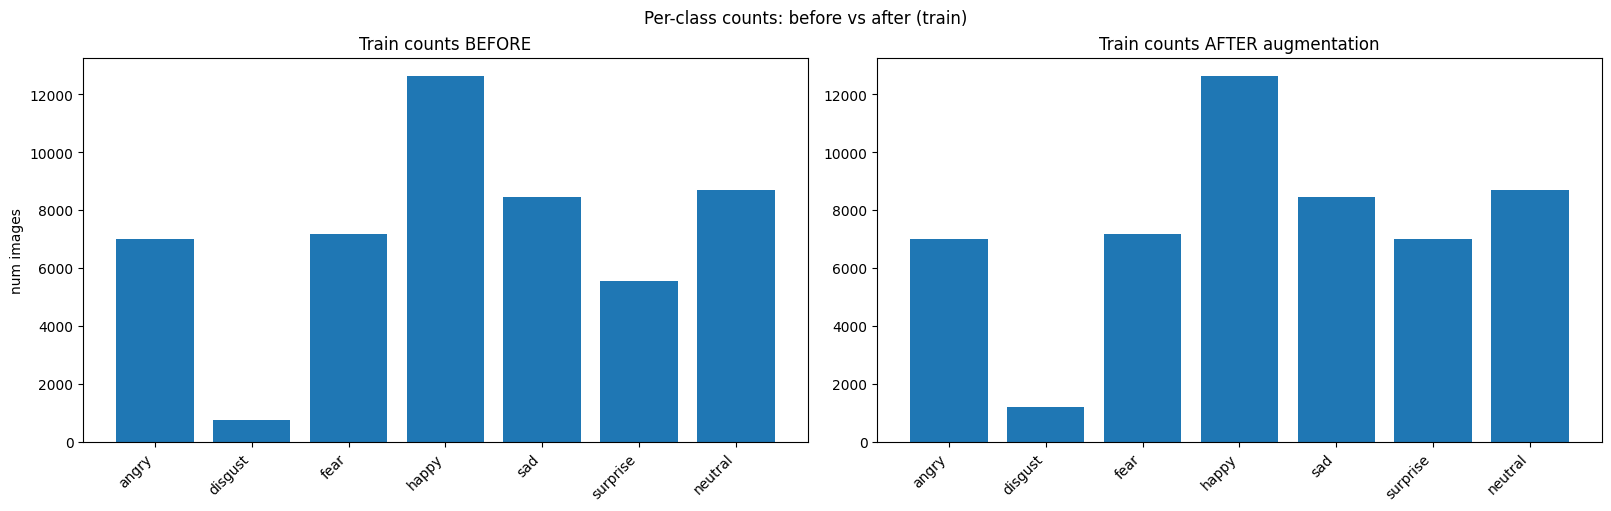

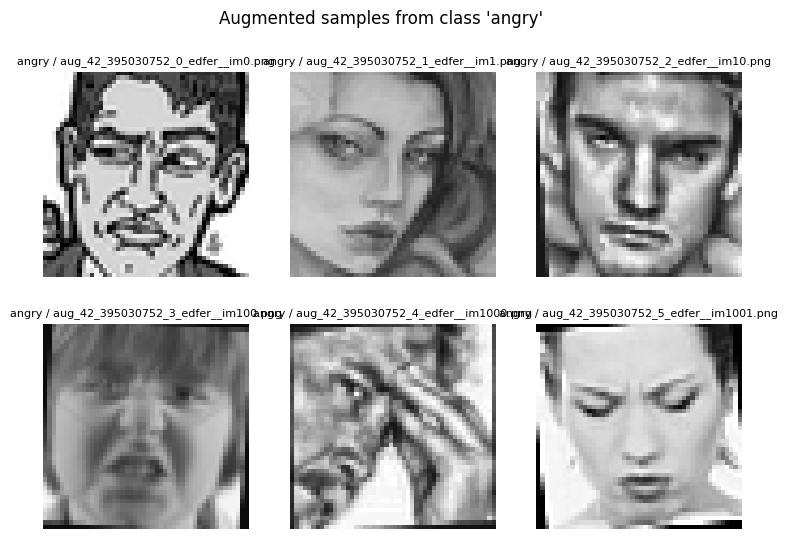

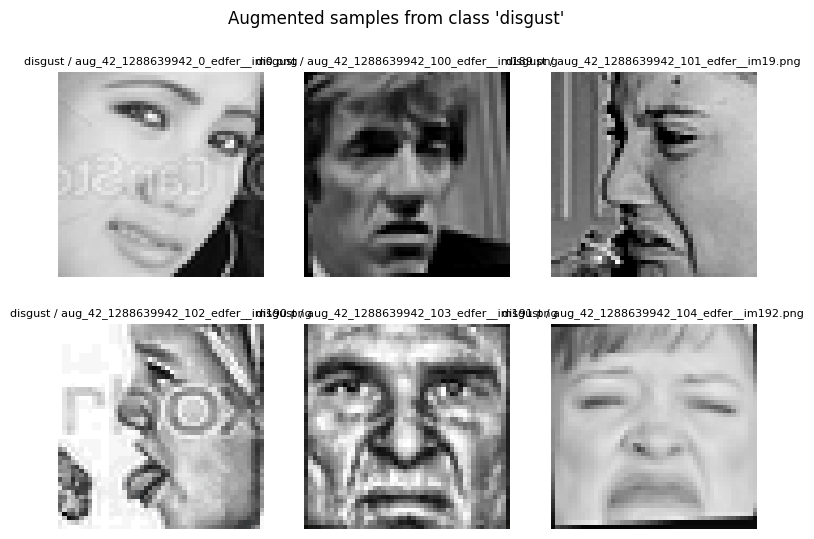

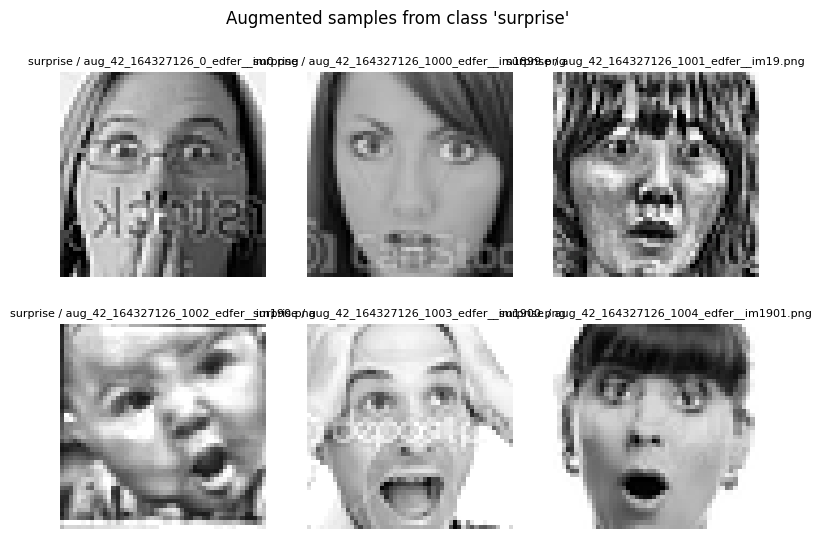

In [5]:
#  plot before (approx) vs after counts and show some augmented samples
import os
import matplotlib.pyplot as plt
from PIL import Image

OUT_ROOT = "/kaggle/content/fer2013_by_usage_1"
TRAIN_DIR = os.path.join(OUT_ROOT, "train")
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp")

def is_image(fn):
    return fn.lower().endswith(IMG_EXTS)

classes = [d for d in sorted(os.listdir(TRAIN_DIR)) if os.path.isdir(os.path.join(TRAIN_DIR, d))]
counts_after = {c: sum(1 for f in os.listdir(os.path.join(TRAIN_DIR,c)) if is_image(f)) for c in classes}
# approximate before by excluding aug_ files (if we copied train from original, these won't exist)
counts_before = {}
for c in classes:
    p = os.path.join(TRAIN_DIR, c)
    files = [f for f in os.listdir(p) if is_image(f)]
    counts_before[c] = len([f for f in files if not f.startswith("aug_")])

LABEL_ORDER = ['angry','disgust','fear','happy','sad','surprise','neutral']
all_classes = LABEL_ORDER if any(k in counts_after for k in LABEL_ORDER) else sorted(classes)
for c in sorted(classes):
    if c not in all_classes:
        all_classes.append(c)

before_vals = [counts_before.get(c, 0) for c in all_classes]
after_vals  = [counts_after.get(c, 0) for c in all_classes]

x = range(len(all_classes))
fig, axs = plt.subplots(1, 2, figsize=(16,5), constrained_layout=True)
axs[0].bar(x, before_vals)
axs[0].set_xticks(x); axs[0].set_xticklabels(all_classes, rotation=45, ha='right')
axs[0].set_title("Train counts BEFORE"); axs[0].set_ylabel("num images")
axs[1].bar(x, after_vals)
axs[1].set_xticks(x); axs[1].set_xticklabels(all_classes, rotation=45, ha='right')
axs[1].set_title("Train counts AFTER augmentation")
plt.suptitle("Per-class counts: before vs after (train)")
plt.show()

sample_classes = [c for c in classes if any(f.startswith("aug_") for f in os.listdir(os.path.join(TRAIN_DIR,c)))]
sample_classes = sample_classes[:3]  # show up to 3 classes
if not sample_classes:
    print("No 'aug_' images found to display.")
else:
    for cls in sample_classes:
        p = os.path.join(TRAIN_DIR, cls)
        aug_files = [f for f in sorted(os.listdir(p)) if is_image_file(f) and f.startswith("aug_")]
        aug_files = aug_files[:6]  # up to 6 per class
        if not aug_files:
            continue
        n = len(aug_files)
        cols = min(3,n); rows = (n + cols - 1)//cols
        plt.figure(figsize=(cols*3, rows*3))
        for i,fn in enumerate(aug_files):
            fp = os.path.join(p, fn)
            try:
                im = Image.open(fp)
                plt.subplot(rows, cols, i+1)
                plt.imshow(im)
                plt.axis('off')
                plt.title(f"{cls} / {fn}", fontsize=8)
            except Exception as e:
                print("  Error opening", fp, e)
        plt.suptitle(f"Augmented samples from class '{cls}'")
        plt.show()


In [9]:
def undersample_train(
    train_dir,
    out_dir,
    target_per_class=9000,
    seed=42,
    img_exts=(".jpg", ".jpeg", ".png", ".bmp"),
    copy_files=True
):
    
    import os, shutil, random
    os.makedirs(out_dir, exist_ok=True)
    rng_global = random.Random(int(seed))

    def is_image(fn):
        return fn.lower().endswith(img_exts)

    before_counts = {}
    after_counts = {}

    classes = [d for d in sorted(os.listdir(train_dir)) if os.path.isdir(os.path.join(train_dir, d))]
    for cls in classes:
        src_cls = os.path.join(train_dir, cls)
        dst_cls = os.path.join(out_dir, cls)
        os.makedirs(dst_cls, exist_ok=True)

        files = [f for f in sorted(os.listdir(src_cls)) if is_image(f)]
        before_counts[cls] = len(files)

        if len(files) <= target_per_class:
            sel = files
        else:
            # deterministic class-specific sampling
            cls_seed = int(seed) + (abs(hash(cls)) % (2**31))
            rng = random.Random(cls_seed)
            files_shuf = list(files)
            rng.shuffle(files_shuf)
            sel = files_shuf[:target_per_class]

        copied = 0
        for fn in sel:
            src_fp = os.path.join(src_cls, fn)
            dst_fp = os.path.join(dst_cls, fn)
            if os.path.exists(dst_fp):
                copied += 1
                continue
            try:
                if copy_files:
                    shutil.copy2(src_fp, dst_fp)
                else:
                    shutil.move(src_fp, dst_fp)
                copied += 1
            except Exception as e:
                print(f"Warning: failed to copy/move {src_fp} -> {dst_fp}: {e}")

        after_counts[cls] = copied

    # print brief summary
    total_before = sum(before_counts.values())
    total_after = sum(after_counts.values())
    print(f"Undersample summary: total before = {total_before}, total after = {total_after}")
    for cls in sorted(before_counts.keys()):
        b = before_counts[cls]; a = after_counts.get(cls, 0)
        if b != a:
            print(f"  {cls:12}: before={b:6}  after={a:6}")
    return before_counts, after_counts

# Example usage:
OUT_UNDER = os.path.join(OUT_ROOT, "train_undersampled")
before, after = undersample_train(TRAIN_DIR, OUT_UNDER, target_per_class=9000, seed=SEED, copy_files=True)
#

Undersample summary: total before = 48511, total after = 48511


In [10]:
# CELL 1
import os
import json
import numpy as np
import tensorflow as tf
from pathlib import Path

# ---------------- USER CONFIG ----------------
SEED = 42
OUT_ROOT = "/kaggle/content/fer2013_by_usage_1"
TRAIN_DIR = os.path.join(OUT_ROOT, "train_undersampled")
VAL_DIR   = os.path.join(OUT_ROOT, "val")
BATCH_SIZE = 64
IMAGE_SIZE = 224
AUTOTUNE = tf.data.AUTOTUNE

EPOCHS = 30
FIRST_PHASE_EPOCHS = 10 # freeze backbone for these
SECOND_PHASE_EPOCHS = EPOCHS - FIRST_PHASE_EPOCHS

LOCAL_WEIGHTS_ENV = "PRETRAINED_WEIGHTS_PATH"
CLASS_WEIGHTS_PATH_ENV = "CLASS_WEIGHTS_PATH"
# ------------------------------------------------

tf.random.set_seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# --- datasets ---
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='int', batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=SEED
)
val_ds = None
if os.path.isdir(VAL_DIR):
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        VAL_DIR, labels='inferred', label_mode='int', batch_size=BATCH_SIZE,
        image_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=False, seed=SEED
    )

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)
print("Num classes:", num_classes)

# compute counts per class (used for fallback class-weights)
def count_images_per_class(root_dir, class_names):
    counts = []
    root = Path(root_dir)
    for c in class_names:
        p = root / c
        if not p.exists():
            counts.append(0)
        else:
            files = [f for f in p.iterdir() if f.is_file()]
            counts.append(len(files))
    return np.array(counts, dtype=np.int64)

disk_counts = count_images_per_class(TRAIN_DIR, class_names)
print("Train counts per class :", disk_counts)

# --- augmentation & preprocessing ---
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),            
    tf.keras.layers.RandomRotation(0.08),                
    tf.keras.layers.RandomTranslation(0.06, 0.06),       
    tf.keras.layers.RandomZoom((-0.04, 0.04)),           
    tf.keras.layers.RandomContrast(0.06),   
])
preprocess_input = tf.keras.applications.resnet.preprocess_input

def prepare_for_training(image, label, augment=True):
    image = tf.cast(image, tf.float32)
    if augment:
        image = data_augmentation(image)
    image = preprocess_input(image)
    return image, label

def prepare_for_eval(image, label):
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    return image, label

# Map/pre-fetch datasets
train_ds = train_ds.map(lambda x, y: prepare_for_training(x, y, augment=True), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)
if val_ds:
    val_ds = val_ds.map(lambda x, y: prepare_for_eval(x, y), num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.prefetch(AUTOTUNE)


Found 48511 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Num classes: 7
Train counts per class : [7000 1200 7170 9000 8689 8452 7000]


In [11]:
# CELL 2
import numpy as np
import tensorflow as tf

# --- helper: load class weights from file or fallback to inverse-frequency ---
def load_class_weights_from_file(path, expected_len):
    path = os.path.expanduser(path)
    ext = os.path.splitext(path)[1].lower()
    if ext in (".csv", ".txt"):
        try:
            arr = np.loadtxt(path, delimiter=',')
        except Exception:
            arr = np.loadtxt(path)
    elif ext == ".json":
        with open(path, 'r') as f:
            data = json.load(f)
        if isinstance(data, dict):
            arr = np.array(list(data.values()), dtype=np.float32)
        else:
            arr = np.array(data, dtype=np.float32)
    else:
        arr = np.loadtxt(path)
    arr = np.array(arr, dtype=np.float32).reshape(-1)
    if arr.shape[0] != expected_len:
        raise ValueError(f"Loaded class-weights length {arr.shape[0]} != expected {expected_len}")
    return arr

def get_class_weight_dict(num_classes, try_path=None):
    if try_path:
        try:
            arr = load_class_weights_from_file(try_path, num_classes)
            print("Loaded class weights from file:", try_path)
            arr = arr / np.mean(arr)
            return {i: float(arr[i]) for i in range(num_classes)}
        except Exception as e:
            print("Failed to load class weights from file:", e)
    eps = 1e-6
    inv = 1.0 / (disk_counts + eps)
    inv = inv / np.mean(inv)
    print("Using computed inverse-frequency class weights.")
    return {i: float(inv[i]) for i in range(num_classes)}

cw_path = os.environ.get(CLASS_WEIGHTS_PATH_ENV, None)
class_weight = get_class_weight_dict(num_classes, try_path=cw_path)
print("Class weights mapping:", class_weight)

# --- load ResNet50 backbone (imagenet if available else local) ---
def load_resnet50_backbone(image_size):
    try:
        print("Loading ResNet50 imagenet weights...")
        base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,
                                              input_shape=(image_size, image_size, 3), pooling='avg')
        return base
    except Exception as e:
        print("Failed to load imagenet weights:", e)
    local_path = os.environ.get(LOCAL_WEIGHTS_ENV)
    if local_path and os.path.isfile(os.path.expanduser(local_path)):
        base = tf.keras.applications.ResNet50(weights=None, include_top=False,
                                              input_shape=(image_size, image_size, 3), pooling='avg')
        try:
            base.load_weights(os.path.expanduser(local_path), by_name=True)
            print("Loaded local weights.")
            return base
        except Exception as e_local:
            print("Failed local load:", e_local)
    raise RuntimeError("Could not load ResNet50 pretrained weights.")

base_model = load_resnet50_backbone(IMAGE_SIZE)

# --- build top/head ---
base_model.trainable = False
inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

outputs = tf.keras.layers.Dense(num_classes, activation='softmax',
                                kernel_regularizer=tf.keras.regularizers.l2(5e-4))(x)
model = tf.keras.Model(inputs, outputs)

# --------------------
# Macro metrics (store confusion matrix as weight and compute macro average)
# --------------------
class ConfMatMetricBase(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name, **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = int(num_classes)
        self.cm = self.add_weight(name='confmat', shape=(self.num_classes, self.num_classes),
                                  initializer='zeros', dtype=tf.float32)

    def _update_confmat(self, y_true, y_pred):
        preds = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
        y_true = tf.reshape(tf.cast(y_true, tf.int32), [-1])
        preds = tf.reshape(tf.cast(preds, tf.int32), [-1])
        batch_cm = tf.cast(tf.math.confusion_matrix(y_true, preds, num_classes=self.num_classes, dtype=tf.float32), tf.float32)
        self.cm.assign_add(batch_cm)

class MacroPrecision(ConfMatMetricBase):
    def __init__(self, num_classes, name='macro_precision', **kwargs):
        super().__init__(num_classes, name, **kwargs)
    def update_state(self, y_true, y_pred, sample_weight=None):
        self._update_confmat(y_true, y_pred)
    def result(self):
        tp = tf.linalg.tensor_diag_part(self.cm)
        predicted = tf.reduce_sum(self.cm, axis=0)
        precision_per_class = tf.where(predicted > 0, tp / predicted, tf.zeros_like(predicted))
        return tf.reduce_mean(precision_per_class)
    def reset_states(self):
        self.cm.assign(tf.zeros_like(self.cm))

class MacroRecall(ConfMatMetricBase):
    def __init__(self, num_classes, name='macro_recall', **kwargs):
        super().__init__(num_classes, name, **kwargs)
    def update_state(self, y_true, y_pred, sample_weight=None):
        self._update_confmat(y_true, y_pred)
    def result(self):
        tp = tf.linalg.tensor_diag_part(self.cm)
        actual = tf.reduce_sum(self.cm, axis=1)
        recall_per_class = tf.where(actual > 0, tp / actual, tf.zeros_like(actual))
        return tf.reduce_mean(recall_per_class)
    def reset_states(self):
        self.cm.assign(tf.zeros_like(self.cm))

class MacroF1(ConfMatMetricBase):
    def __init__(self, num_classes, name='macro_f1', **kwargs):
        super().__init__(num_classes, name, **kwargs)
    def update_state(self, y_true, y_pred, sample_weight=None):
        self._update_confmat(y_true, y_pred)
    def result(self):
        tp = tf.linalg.tensor_diag_part(self.cm)
        predicted = tf.reduce_sum(self.cm, axis=0)
        actual = tf.reduce_sum(self.cm, axis=1)
        precision_per_class = tf.where(predicted > 0, tp / predicted, tf.zeros_like(predicted))
        recall_per_class = tf.where(actual > 0, tp / actual, tf.zeros_like(actual))
        f1_per_class = tf.where((precision_per_class + recall_per_class) > 0,
                                2.0 * precision_per_class * recall_per_class / (precision_per_class + recall_per_class),
                                tf.zeros_like(precision_per_class))
        return tf.reduce_mean(f1_per_class)
    def reset_states(self):
        self.cm.assign(tf.zeros_like(self.cm))

# compile for phase 1 (head only)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
             MacroPrecision(num_classes=num_classes),
             MacroRecall(num_classes=num_classes),
             MacroF1(num_classes=num_classes)]
)

# safe formatting helper and print callback
def safe_fmt(x, precision=4):
    try:
        if isinstance(x, (tf.Tensor, np.generic)):
            x = x.numpy() if hasattr(x, "numpy") else float(x)
        return f"{float(x):.{precision}f}"
    except Exception:
        return "   N/A"

class PrintMetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        train_acc = logs.get('accuracy') or logs.get('sparse_categorical_accuracy')
        val_acc = logs.get('val_accuracy') or logs.get('val_sparse_categorical_accuracy')
        s = (f"[Epoch {epoch+1:02d}] train_loss={safe_fmt(train_loss)} train_acc={safe_fmt(train_acc)} | "
             f"val_loss={safe_fmt(val_loss)} val_acc={safe_fmt(val_acc)}")
        print(s)

print("Starting Phase 1 (train head)...")
history1 = model.fit(train_ds, validation_data=val_ds, epochs=FIRST_PHASE_EPOCHS, callbacks=[PrintMetricsCallback()],class_weight=class_weight)


Using computed inverse-frequency class weights.
Class weights mapping: {0: 0.6238178738767065, 1: 3.6389375951015213, 2: 0.609027212991874, 3: 0.48519167969728577, 4: 0.5025578452362994, 5: 0.5166499192196065, 6: 0.6238178738767065}
Loading ResNet50 imagenet weights...
Starting Phase 1 (train head)...
Epoch 1/10
758/758 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.2949 - loss: 1.1934 - macro_f1: 0.2738 - macro_precision: 0.2829 - macro_recall: 0.3102[Epoch 01] train_loss=1.0773 train_acc=0.3471 | val_loss=1.4521 val_acc=0.4624
758/758 ━━━━━━━━━━━━━━━━━━━━ 368s 461ms/step - accuracy: 0.2950 - loss: 1.1933 - macro_f1: 0.2738 - macro_precision: 0.2829 - macro_recall: 0.3102 - val_accuracy: 0.4624 - val_loss: 1.4521 - val_macro_f1: 0.4009 - val_macro_precision: 0.4236 - val_macro_recall: 0.4608
Epoch 2/10
758/758 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.4149 - loss: 0.9465 - macro_f1: 0.3841 - macro_precision: 0.3877 - macro_recall: 0.4321[Epoch 02] train_loss=0.9355 train_acc=

Using AdamW optimizer with weight_decay.
Starting Phase 2: fine-tuning (initial lr=8.0e-05) ...
Epoch 11/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.4428 - loss: 0.9112 - macro_f1: 0.4137 - macro_precision: 0.4135 - macro_recall: 0.4673[Epoch 11] train_loss=0.8117 train_acc=0.5013 | val_loss=1.2111 val_acc=0.5584
758/758 ━━━━━━━━━━━━━━━━━━━━ 473s 516ms/step - accuracy: 0.4429 - loss: 0.9111 - macro_f1: 0.4138 - macro_precision: 0.4136 - macro_recall: 0.4674 - val_accuracy: 0.5584 - val_loss: 1.2111 - val_macro_f1: 0.5032 - val_macro_precision: 0.5401 - val_macro_recall: 0.5804 - learning_rate: 8.0000e-05
Epoch 12/30
758/758 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.5913 - loss: 0.6712 - macro_f1: 0.5692 - macro_precision: 0.5575 - macro_recall: 0.6188[Epoch 12] train_loss=0.6503 train_acc=0.6051 | val_loss=0.9549 val_acc=0.6581
758/758 ━━━━━━━━━━━━━━━━━━━━ 358s 470ms/step - accuracy: 0.5913 - loss: 0.6711 - macro_f1: 0.5693 - macro_precision: 0.5576 - macro_recal

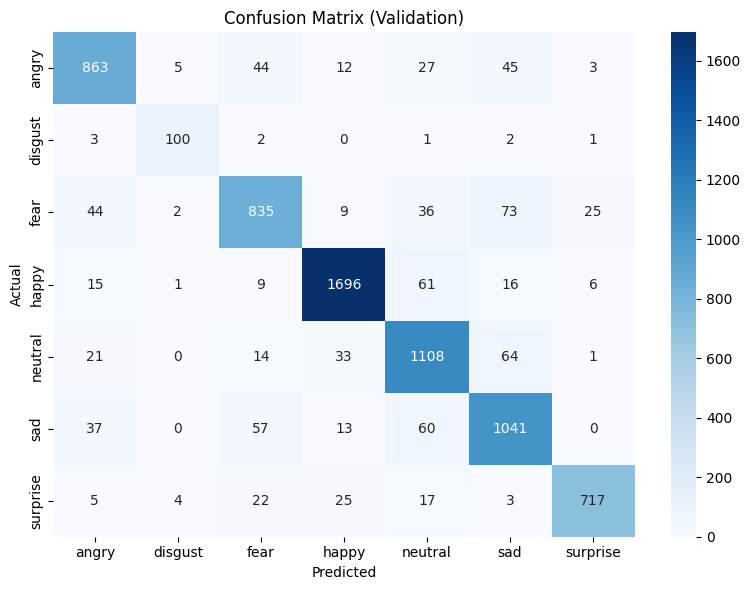

Saved: /kaggle/working/confusion_matrix_val.png


In [12]:
# ------------------ CELL 3 (modified) ------------------
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import os

# Phase 2: unfreeze some of the backbone 
N_unfreeze = 50  
for layer in base_model.layers[:-N_unfreeze]:
    layer.trainable = False
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
base_model.trainable = True

INITIAL_LR = (1e-4)*(0.8)
INITIAL_WEIGHT_DECAY = (1e-4)

try:
    # TF 2.11+ may expose AdamW in either tf.keras.optimizers or tf.keras.optimizers.experimental
    AdamW = getattr(tf.keras.optimizers, "AdamW", None) or getattr(tf.keras.optimizers, "experimental", None) and getattr(tf.keras.optimizers.experimental, "AdamW", None)
    if AdamW is None:
        raise AttributeError
    optimizer = AdamW(learning_rate=INITIAL_LR, weight_decay=INITIAL_WEIGHT_DECAY)
    print("Using AdamW optimizer with weight_decay.")
except Exception:
    optimizer = tf.keras.optimizers.Adam(learning_rate=INITIAL_LR)
    print("AdamW not found — using standard Adam (no optimizer weight decay). "
          "Consider adding kernel_regularizer=l2(...) to layers if you want L2 regularization.")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",   
    factor=0.5,           # multiply LR by this factor when plateau
    patience=2,           # number of epochs with no improvement before reducing LR
    verbose=1,
    min_lr=1e-7
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",   # stop when this stops improving
    patience=6,          # how many epochs to wait after last improvement
    restore_best_weights=True,
    verbose=1
)

class IncreaseWeightDecayOnLRDrop(tf.keras.callbacks.Callback):
    def __init__(self, factor=1.5, max_weight_decay=1e-3):
        super().__init__()
        self.factor = factor
        self.max_weight_decay = max_weight_decay
        self._prev_lr = None

    def on_train_begin(self, logs=None):
        # capture initial lr
        try:
            self._prev_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        except Exception:
            # fallback for optimizers exposing 'lr'
            try:
                self._prev_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
            except Exception:
                self._prev_lr = None

    def on_epoch_end(self, epoch, logs=None):
        # get current lr value robustly
        cur_lr = None
        try:
            cur_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        except Exception:
            try:
                cur_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
            except Exception:
                cur_lr = None

        # if lr dropped since last epoch, try to bump weight decay
        if self._prev_lr is not None and cur_lr is not None and cur_lr < self._prev_lr - 1e-12:
            opt = self.model.optimizer
            # try common attribute names for weight decay
            wd_attr_names = ["weight_decay", "decay", "weightDecay"]
            for name in wd_attr_names:
                if hasattr(opt, name):
                    try:
                        current_wd = getattr(opt, name)
                        # if it's a tf.Variable or a wrapper, attempt to extract a float
                        try:
                            current_wd_val = float(tf.keras.backend.get_value(current_wd))
                        except Exception:
                            current_wd_val = float(current_wd)
                        new_wd = min(current_wd_val * self.factor, self.max_weight_decay)
                        # try assign if tf.Variable-like
                        try:
                            tf.keras.backend.set_value(getattr(opt, name), new_wd)
                        except Exception:
                            try:
                                setattr(opt, name, new_wd)
                            except Exception:
                                print(f"[IncreaseWeightDecayOnLRDrop] Could not set {name} on optimizer.")
                        print(f"[IncreaseWeightDecayOnLRDrop] LR decreased => increased {name} from {current_wd_val:.2e} to {new_wd:.2e}")
                        break
                    except Exception as e:
                        print("[IncreaseWeightDecayOnLRDrop] error while updating weight decay:", e)
            else:
                # No known weight-decay attribute exposed
                print("[IncreaseWeightDecayOnLRDrop] optimizer does not expose a writable weight-decay attribute; skipping.")
        # update prev_lr for next epoch
        if cur_lr is not None:
            self._prev_lr = cur_lr

# Instantiate the optional callback (set to False to disable)
use_increase_wd_callback = True
increase_wd_cb = IncreaseWeightDecayOnLRDrop(factor=1.5, max_weight_decay=1e-3) if use_increase_wd_callback else None

# -------------------------
# Compile model
# -------------------------
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
             MacroPrecision(num_classes=num_classes),
             MacroRecall(num_classes=num_classes),
             MacroF1(num_classes=num_classes)]
)

# -------------------------
# Fit: note we no longer use an epoch-based LR scheduler
# -------------------------
callbacks_list = [reduce_lr, early_stop, PrintMetricsCallback()]
if increase_wd_cb is not None:
    callbacks_list.append(increase_wd_cb)

print(f"Starting Phase 2: fine-tuning (initial lr={INITIAL_LR:.1e}) ...")
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    initial_epoch=FIRST_PHASE_EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks_list
)

print("Training complete. Running final evaluation (no augmentation)...")

# (evaluation + confusion-matrix code follows unchanged)
# create clean evaluation dataset for train/val (no augmentation)
train_eval_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='int', batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=False
).map(lambda x,y: prepare_for_eval(x,y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

train_eval = model.evaluate(train_eval_ds, verbose=0)
if isinstance(train_eval, (list, tuple)) and len(train_eval) >= 2:
    train_loss, train_acc = train_eval[0], train_eval[1]
else:
    train_loss, train_acc = train_eval, None

if val_ds:
    val_eval = model.evaluate(val_ds, verbose=0)
    if isinstance(val_eval, (list, tuple)) and len(val_eval) >= 2:
        val_loss, val_acc = val_eval[0], val_eval[1]
    else:
        val_loss, val_acc = val_eval, None
else:
    val_loss = val_acc = None

print(f"Train - loss: {train_loss:.4f} acc: {train_acc:.4f}" if train_acc is not None else f"Train - loss: {train_loss:.4f}")
if val_ds and val_acc is not None:
    print(f"Val   - loss: {val_loss:.4f} acc: {val_acc:.4f}")
elif val_ds:
    print(f"Val   - loss: {val_loss:.4f}")
else:
    print("Val   - N/A")

# -------------------- validation confusion matrix (seaborn 'Blues') --------------------
def plot_confusion_matrix_seaborn(model, dataset, class_names, title="Confusion Matrix (Val)", save_path='confusion_matrix_val.png'):
    ys, preds = [], []
    for batch_x, batch_y in dataset:
        batch_preds = model.predict(batch_x, verbose=0)
        pred_labels = np.argmax(batch_preds, axis=-1)
        ys.append(batch_y.numpy().reshape(-1))
        preds.append(pred_labels.reshape(-1))
    if not ys:
        print("No validation data to plot.")
        return
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(preds)

    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    try:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print("Saved:", os.path.abspath(save_path))
    except Exception as e:
        print("Could not save val confusion image:", e)
    plt.close()

if val_ds:
    plot_confusion_matrix_seaborn(model, val_ds, class_names, title="Confusion Matrix (Validation)")


Using test directory: /kaggle/content/fer2013_by_usage_1/test
Found 7178 files belonging to 7 classes.

Test accuracy (raw): 0.9439

Model.evaluate results:
  loss: 0.1831
  compile_metrics: 0.9439

Classification report:
              precision    recall  f1-score   support

       angry     0.9452    0.9363    0.9407       958
     disgust     0.9911    1.0000    0.9955       111
        fear     0.9332    0.9004    0.9165      1024
       happy     0.9775    0.9566    0.9670      1774
     neutral     0.9122    0.9611    0.9360      1233
         sad     0.9095    0.9350    0.9221      1247
    surprise     0.9815    0.9591    0.9702       831

    accuracy                         0.9439      7178
   macro avg     0.9500    0.9498    0.9497      7178
weighted avg     0.9445    0.9439    0.9440      7178



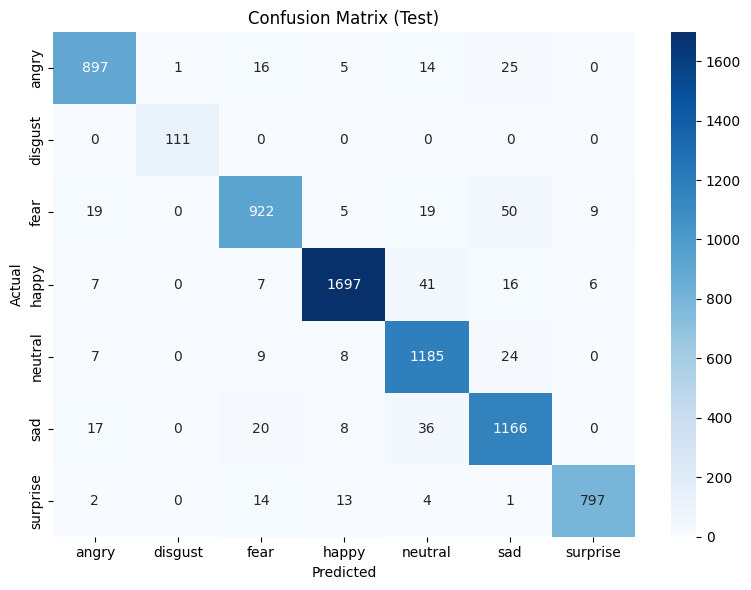

Saved confusion matrix image to: /kaggle/working/confusion_matrix_test.png


In [13]:
# CELL 4 (updated) — test dataset evaluation + classification report + seaborn confusion matrix + test accuracy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# prefer OUT_ROOT/test if exists, otherwise use VAL_DIR as fallback
TEST_DIR = os.path.join(OUT_ROOT, 'test')
print("Using test directory:", TEST_DIR)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR, labels='inferred', label_mode='int', batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=False
).map(lambda x,y: prepare_for_eval(x,y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

y_true, y_pred = [], []
for batch_x, batch_y in test_ds:
    preds = model.predict(batch_x, verbose=0)
    pred_labels = np.argmax(preds, axis=-1)
    y_true.append(batch_y.numpy().reshape(-1))
    y_pred.append(pred_labels.reshape(-1))

if len(y_true) == 0:
    print("No samples in test dataset.")
else:
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # numeric metrics
    test_acc = float(np.mean(y_true == y_pred))
    print(f"\nTest accuracy (raw): {test_acc:.4f}")

    # try model.evaluate to print loss + compiled metrics (if you want the model's metrics)
    try:
        eval_res = model.evaluate(test_ds, verbose=0)
        if isinstance(eval_res, (list, tuple)):
            print("\nModel.evaluate results:")
            for name, val in zip(getattr(model, 'metrics_names', []), eval_res):
                try:
                    print(f"  {name}: {val:.4f}")
                except Exception:
                    print(f"  {name}: {val}")
        else:
            print(f"\nModel.evaluate result: {eval_res}")
    except Exception as e:
        print("model.evaluate failed (safe to ignore):", e)

    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y_true, y_pred)

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # seaborn-style plot exactly like your snippet
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (Test)")
    plt.tight_layout()
    plt.show()

    try:
        out_path = 'confusion_matrix_test.png'
        plt.savefig(out_path, dpi=150, bbox_inches='tight')
        print("Saved confusion matrix image to:", os.path.abspath(out_path))
    except Exception as e:
        print("Could not save confusion matrix image:", e)
    plt.close()
